In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<span style="font-family: monospace">
<h1>Problem Statement</h1>

In this case study, we will be working on Apollo Hospital's dataset to deduce the factors that play significant role in a patient's hospitalization and medical expenses. We will be using the concepts of
1. Data Exporation
2. Feature Engineering
3. Data Vizualization
4. Hypothesis Testing

</span>

In [2]:
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib_inline, seaborn as sns, pylab

from scipy.stats import levene, shapiro, probplot as qqplot, chi2_contingency, ttest_ind, f_oneway

pd.set_option('mode.chained_assignment', None)
pd.set_option('expand_frame_repr', False)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

<span style="font-family: monospace">
<h2>Data Exporation</h2>
</span>

In [3]:
df = pd.read_csv('data.csv')
print(df.head())

   age     sex smoker     region  viral load  severity level  hospitalization charges
0   19  female    yes  southwest        9.30               0                    42212
1   18    male     no  southeast       11.26               1                     4314
2   28    male     no  southeast       11.00               3                    11124
3   33    male     no  northwest        7.57               0                    54961
4   32    male     no  northwest        9.63               0                     9667


In [4]:
df.shape

(1338, 7)

In [5]:
df.dtypes

age                          int64
sex                         object
smoker                      object
region                      object
viral load                 float64
severity level               int64
hospitalization charges      int64
dtype: object

In [6]:
df['severity level'] = df['severity level'].astype(object)

In [7]:
df.describe()

,age,viral load,hospitalization charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


In [8]:
df.describe(include=object)

,sex,smoker,region,severity level
count,1338,1338,1338,1338
unique,2,2,4,6
top,male,no,southeast,0
freq,676,1064,364,574


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   object 
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 73.3+ KB


In [10]:
df.isna().sum()

age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64

In [11]:
for col in df.select_dtypes(object):
    print(f"{'-' * 169}\nValue Counts for Column: {col}\n")
    print(df[col].value_counts())
print('-'*169)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Value Counts for Column: sex

male      676
female    662
Name: sex, dtype: int64
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Value Counts for Column: smoker

no     1064
yes     274
Name: smoker, dtype: int64
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Value Counts for Column: region

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Value Counts for Column: s

<span style="font-family: monospace">

<h3>Observations</h3>
    
    1. We have 1338 data points for 7 features with 0 missing values.
    2. The data is in a clean state with appropriate dtypes except for 'severity level' which we have fixed.
    3. We have balanced data for 'sex' and 'region' columns.
    4. We have unbalanced data for 'smoker' and 'seveity level' columns.

<span style="font-family: monospace">
<h2>Outlier Treatment</h2>
</span>

In [12]:
class OutlierTreatment:
    
    def __init__(self, dataframe, lower_quantile=0.25, upper_quantile=0.75):
        self.dataframe = dataframe
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        return None
    
    def calculate_iqr(self, col_name):
        '''
        The function calculate IQR and return lower and upper bound values.

        :param
            col_name: name of the column to calculate IQR

        :return
            lower_bound: int - lower bound below which all the values are outliers
            upper_bound: int - upper bound above which all the values are outliers
        '''

        q1, q3 = self.dataframe[col_name].quantile(self.lower_quantile), self.dataframe[col_name].quantile(self.upper_quantile)
        
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        return lower_bound, upper_bound


    def outlier_treatment(self):
        '''
        The function drop all the rows with outlying values in the list of columns.

        :param
            column_list: list of columns to treat outliers in

        :return
            dataframe: pd.DataFrame
        '''
        all_indexes_to_drop = []
        for col_name in self.dataframe.select_dtypes([int, float]):
            lower_bound, upper_bound = self.calculate_iqr(col_name)
            outlier_boolean_mask = self.dataframe[col_name].apply(lambda x: True if (x >= upper_bound or x <= lower_bound) else False)
            
            assert self.dataframe[~outlier_boolean_mask].shape[0] == outlier_boolean_mask.value_counts()[False]
            assert self.dataframe[outlier_boolean_mask].shape[1] == self.dataframe.shape[1]
            all_indexes_to_drop.extend(self.dataframe.index[outlier_boolean_mask].tolist())
            
            print(f'\tPercent Outliers for {col_name}: {round(100 - (100 * outlier_boolean_mask.value_counts()[False] / self.dataframe.shape[0]), 3)}%')

        print(f'\n\tTotal Percent Outliers: {round(100 * len(list(set(all_indexes_to_drop))) / self.dataframe.shape[0], 3)}%')
        self.dataframe.drop(list(set(all_indexes_to_drop)), axis=0, inplace=True)

        return None


print(f'Shape of the dataframe before dropping outliers: {df.shape}\n')
OT = OutlierTreatment(df.copy())
OT.outlier_treatment()
processed_df = OT.dataframe.reset_index(drop=True)
print(f'\nShape of the dataframe after dropping outliers: {processed_df.shape}')

Shape of the dataframe before dropping outliers: (1338, 7)

	Percent Outliers for age: 0.0%
	Percent Outliers for viral load: 0.673%
	Percent Outliers for hospitalization charges: 10.389%

	Total Percent Outliers: 10.837%

Shape of the dataframe after dropping outliers: (1193, 7)


<span style="font-family: monospace">
<h2>Data Visualization</h2>
</span>

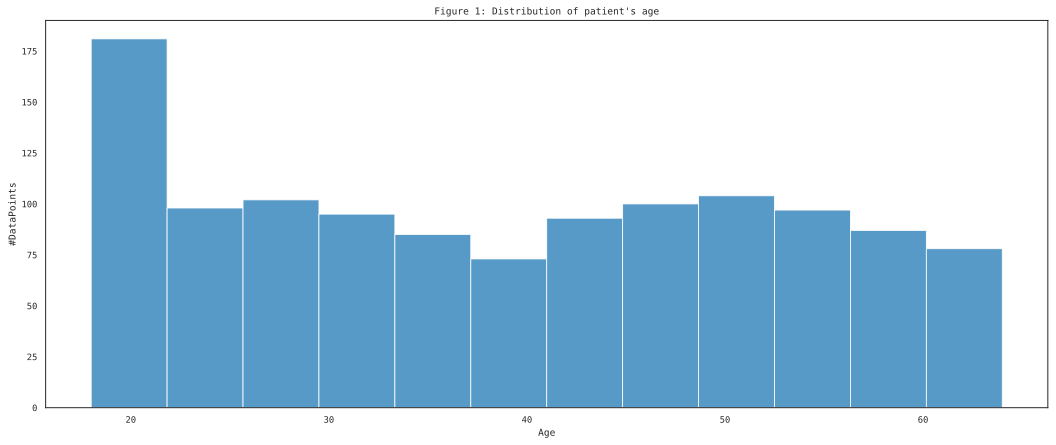

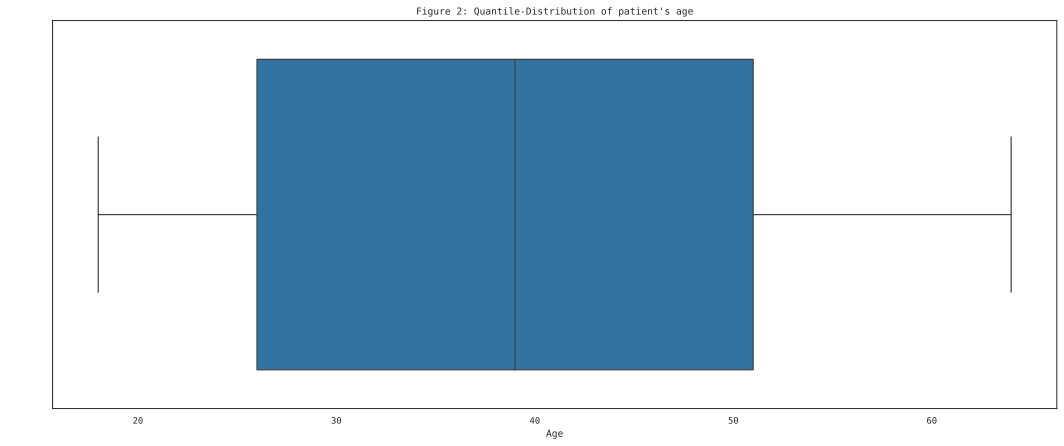

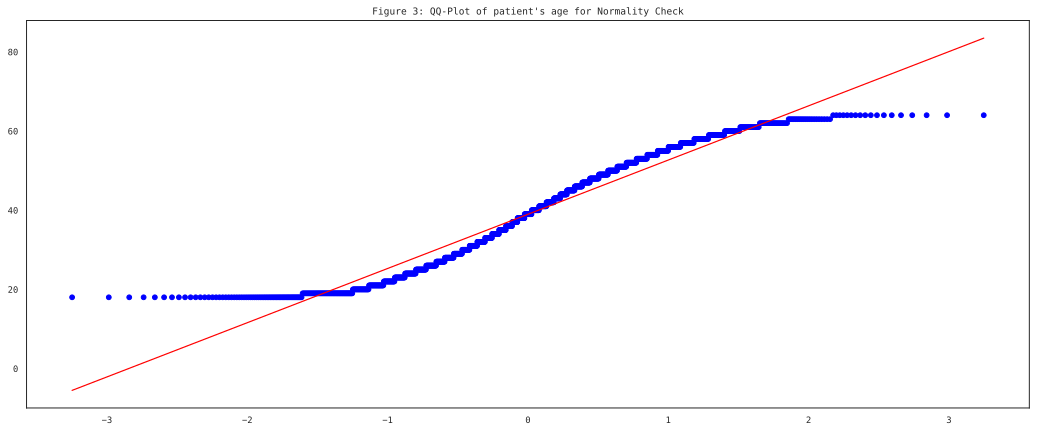

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


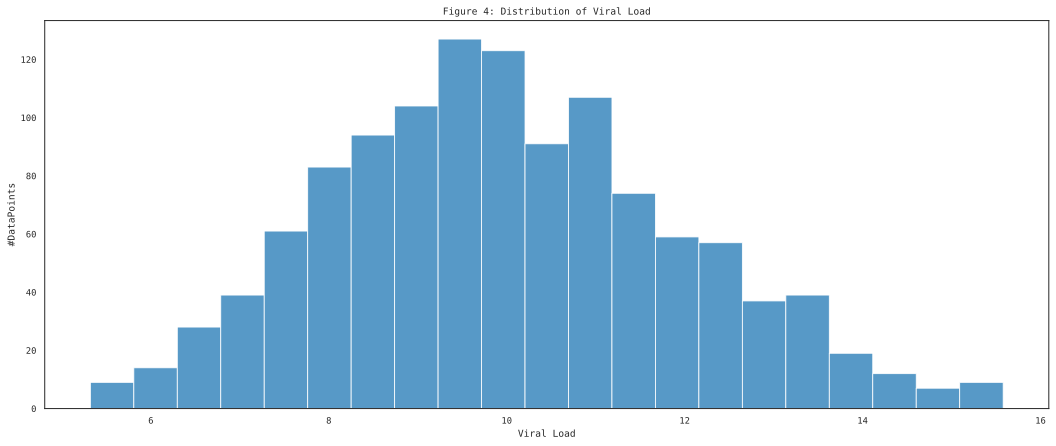

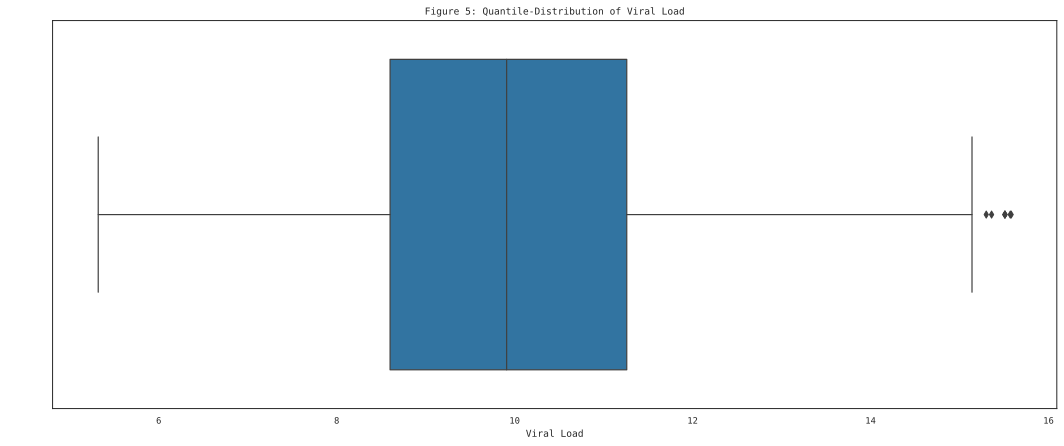

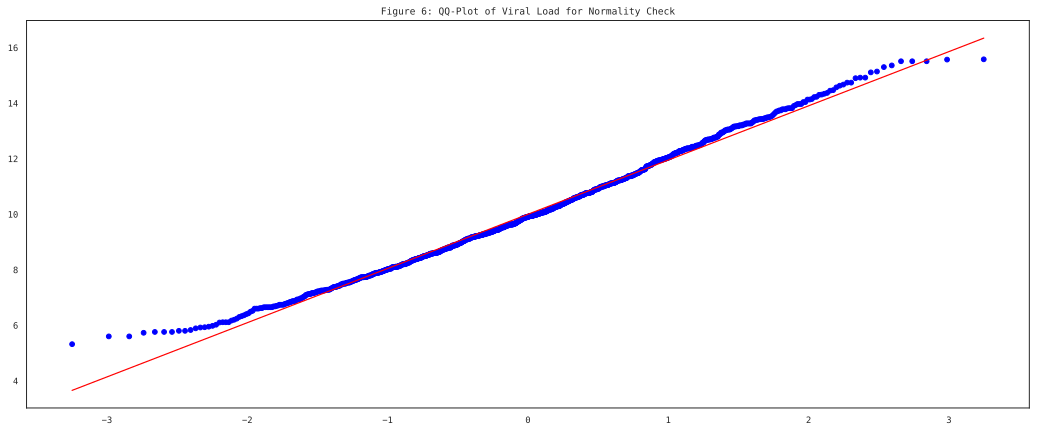

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


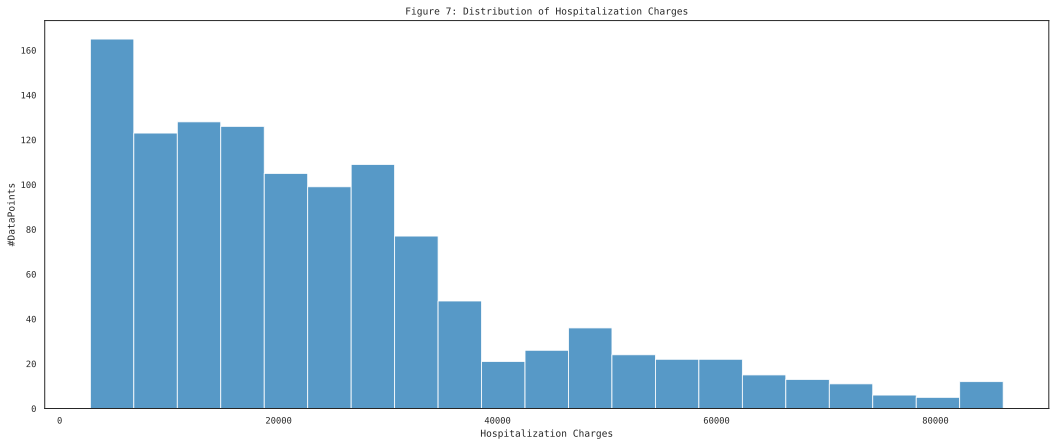

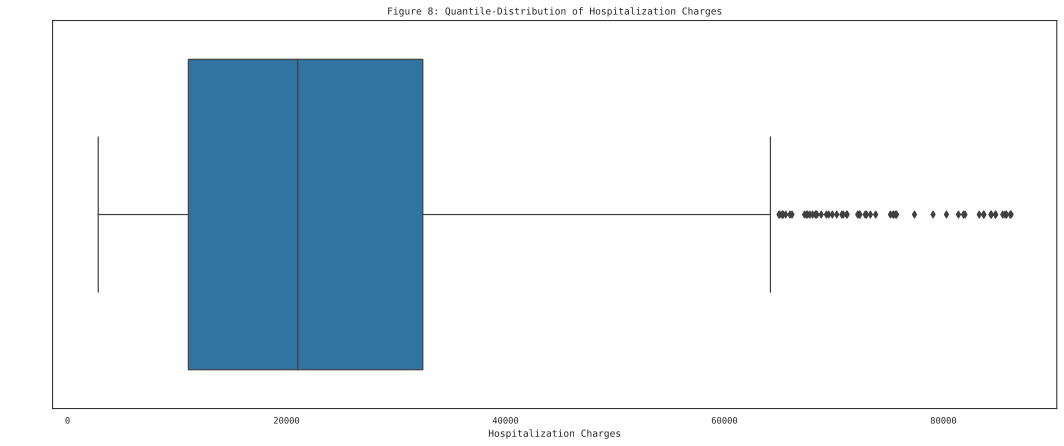

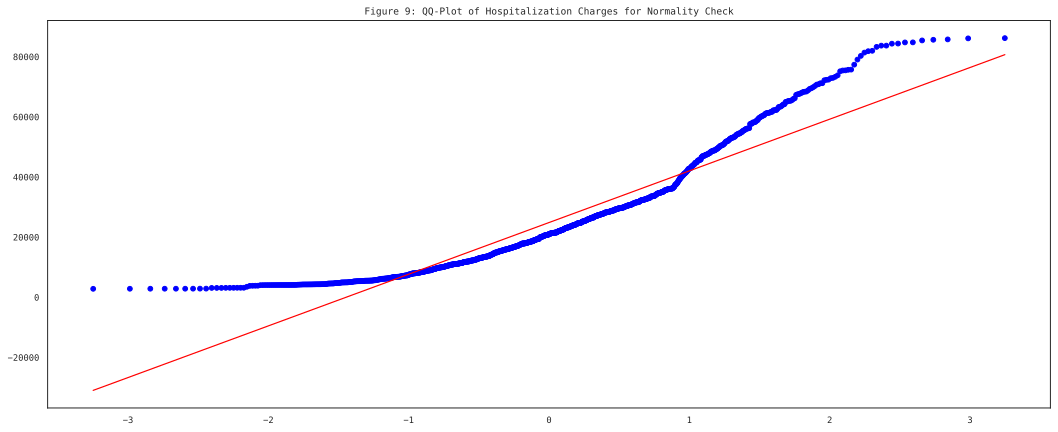

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


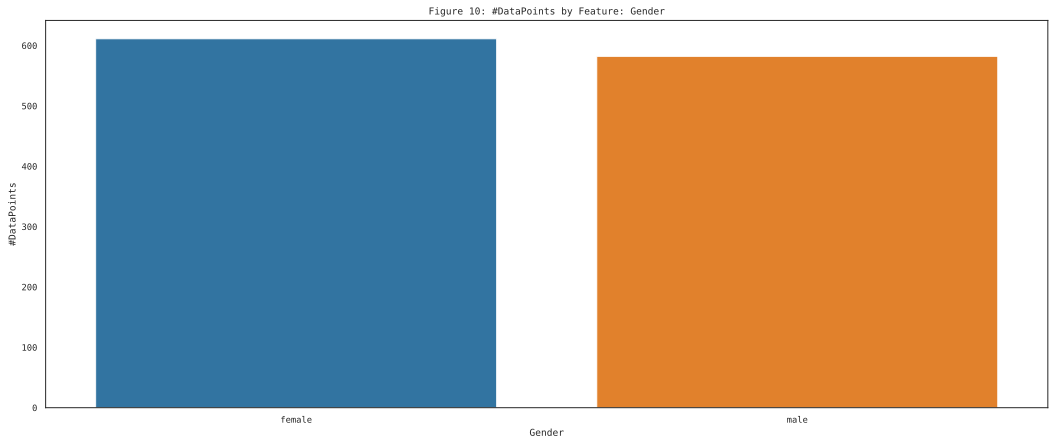

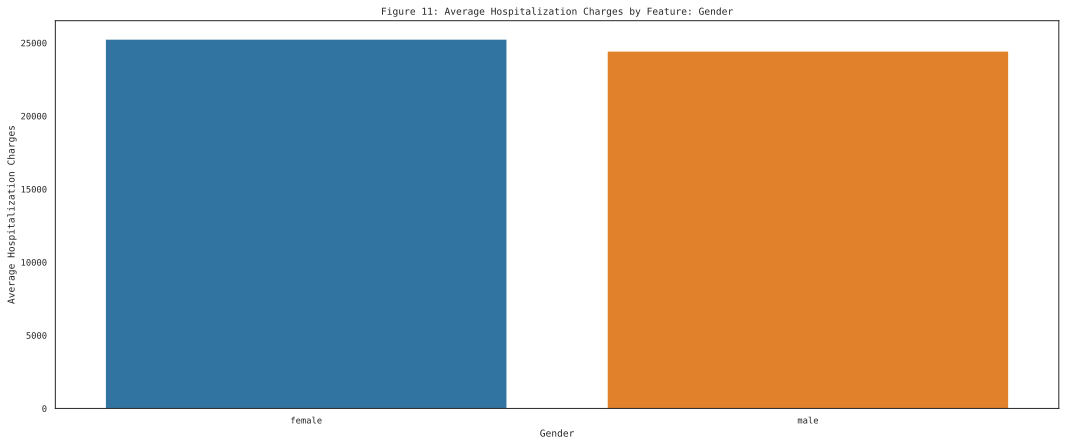

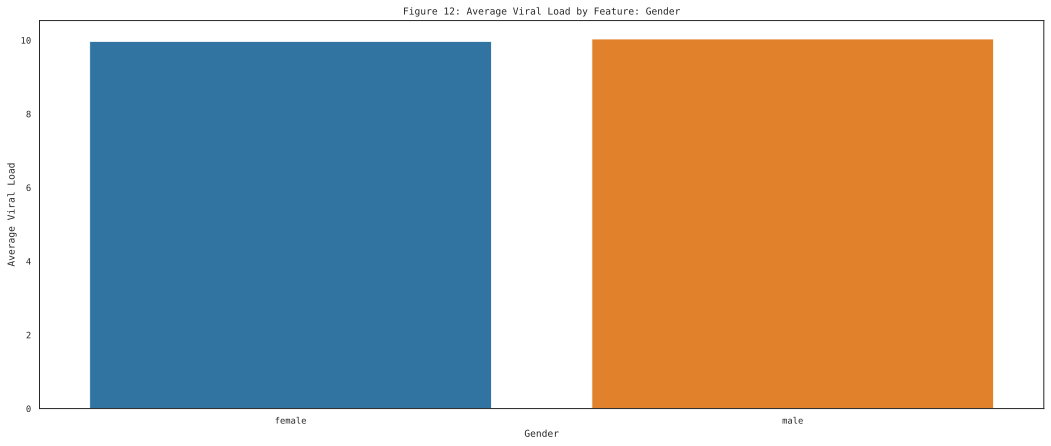

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


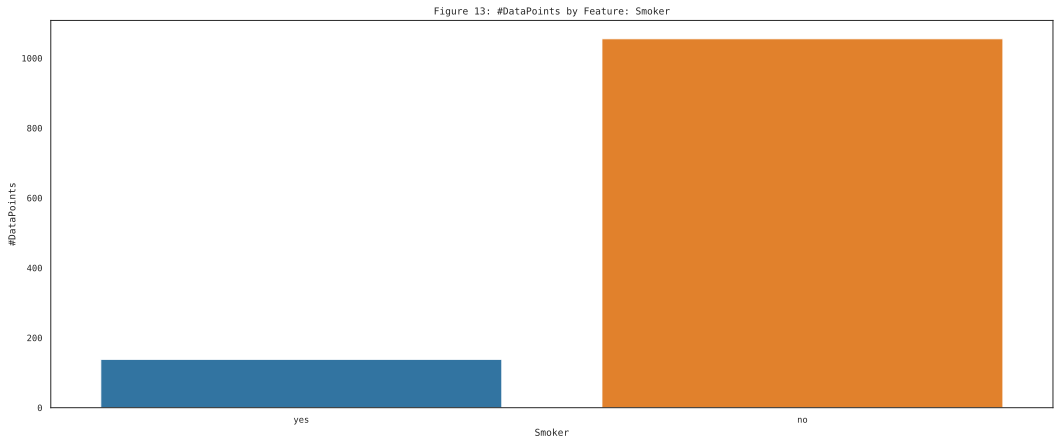

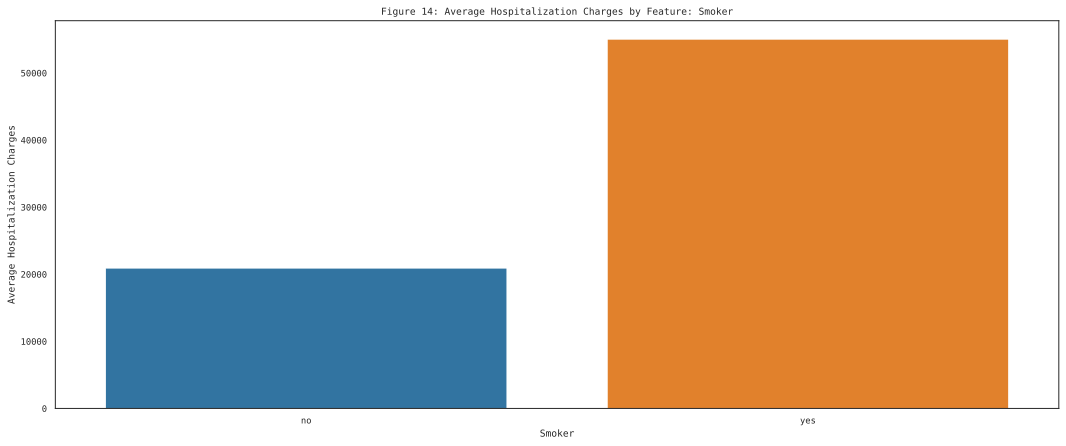

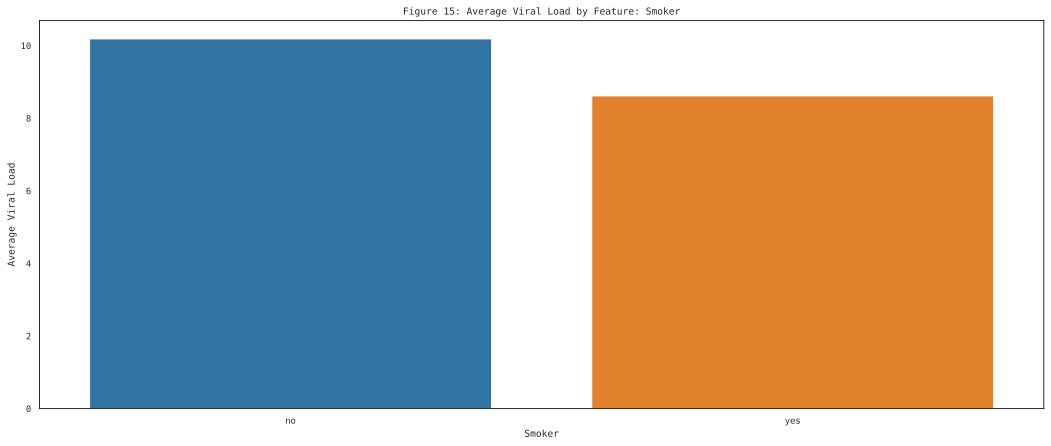

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


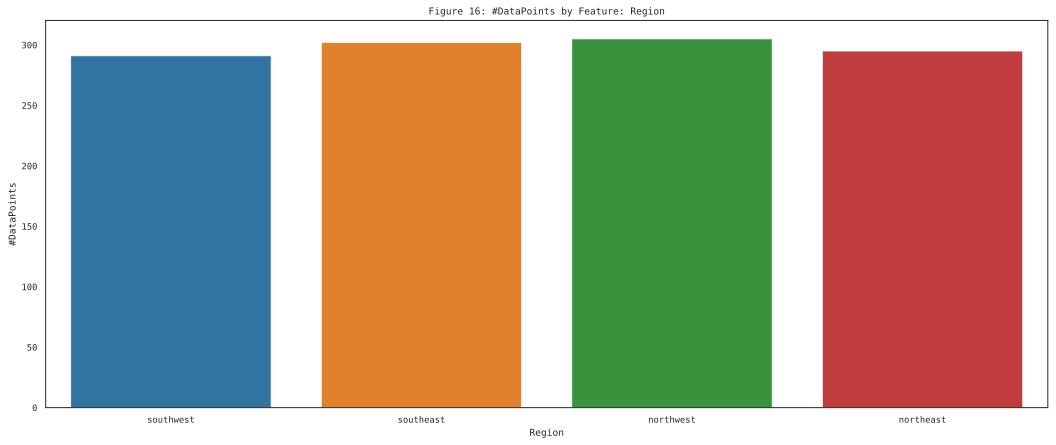

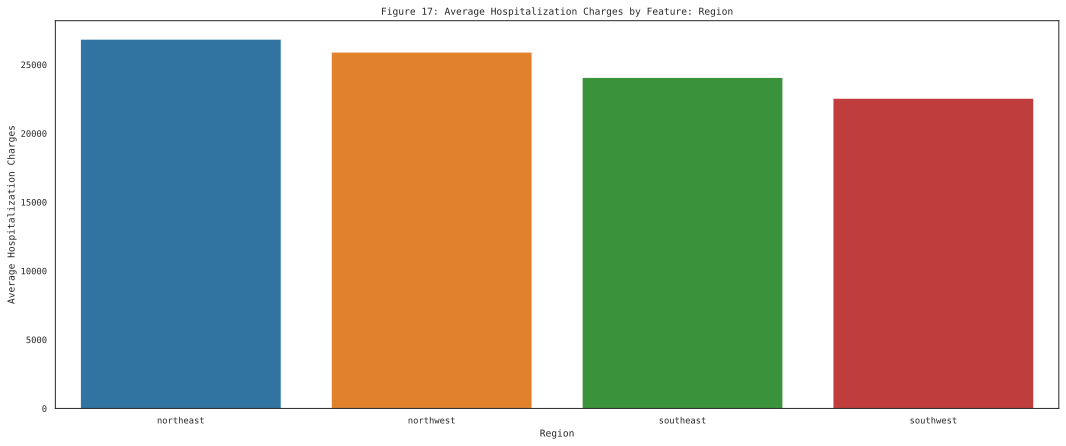

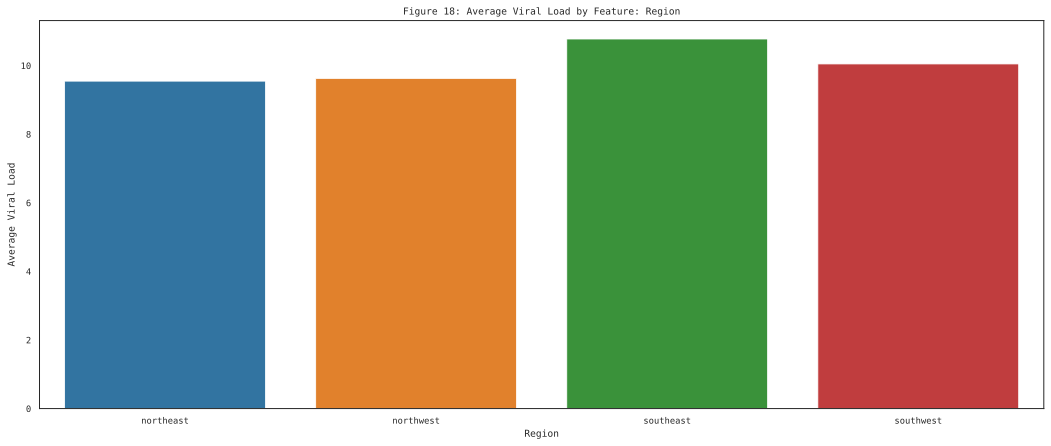

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


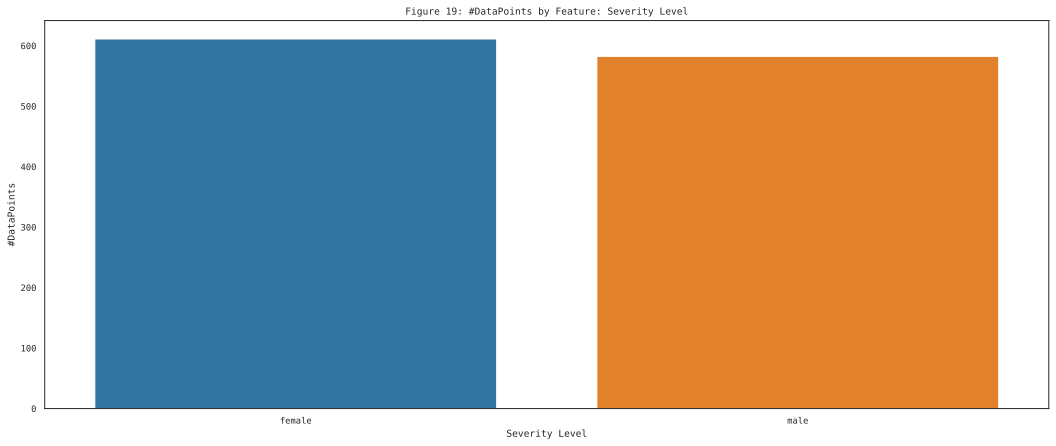

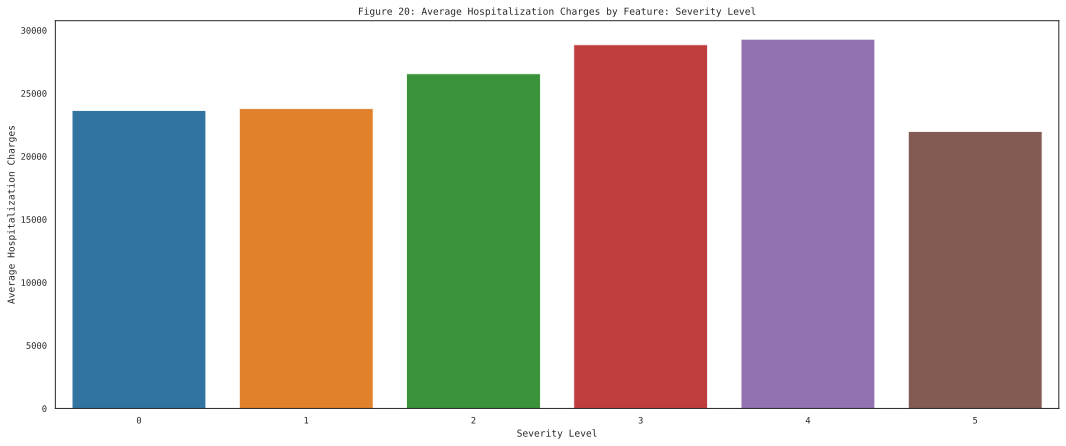

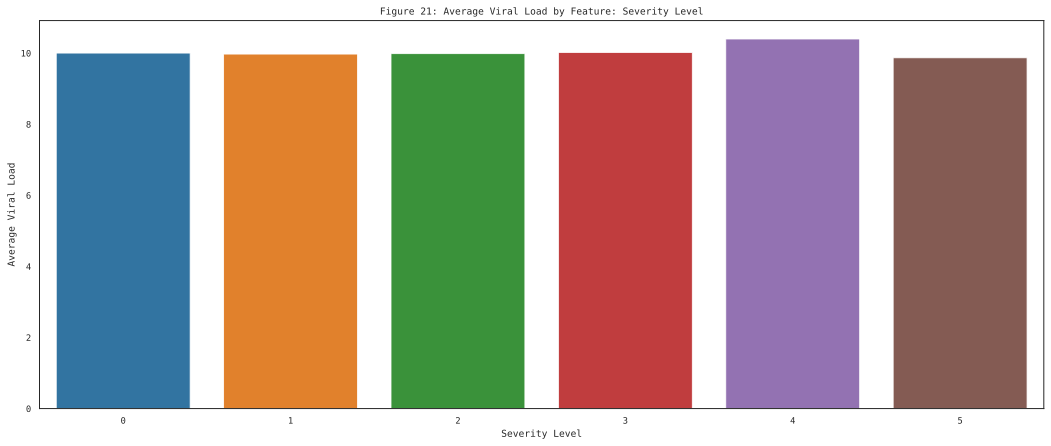

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [13]:
class DataVisualization:
    
    def __init__(self, dataframe, fig_num):
        self.dataframe = dataframe
        self.fig_dict = {'fontname': 'monospace'}
        self.fig_num = fig_num
        return None
    

    def plot_qqplot(self, column_name, viz_title, viz_legend=None, viz_xlabel=None, viz_xticks=None, viz_ylabel=None, viz_yticks=None):
        
        self.fig_num += 1
        plt.figure(figsize=(18, 7))
        sns.despine()
        sns.set_style('white')
        sns.set_context('paper')

        qqplot(self.dataframe[column_name], plot=pylab)
        
        plt.title(f'Figure {self.fig_num}: {viz_title}', **self.fig_dict)

        if viz_legend:
            plt.legend(viz_legend, prop={'family': 'monospace', 'size': 12})
        
        if viz_xticks:
            plt.xticks(viz_xticks, **self.fig_dict)
        else:
            plt.xticks(**self.fig_dict)
            
        if viz_yticks:
            plt.yticks(viz_yticks, **self.fig_dict)
        else:
            plt.yticks(**self.fig_dict)

        if viz_xlabel:
            plt.xlabel(viz_xlabel, **self.fig_dict)
        else:
            plt.xlabel('', **self.fig_dict)

        if viz_ylabel:
            plt.ylabel(viz_ylabel, **self.fig_dict)
        else:
            plt.ylabel('', **self.fig_dict)
        
        plt.show()

        return None

    def plot_histogram(self, column_name, viz_title, viz_legend=None, viz_xlabel=None, viz_xticks=None, viz_ylabel=None, viz_yticks=None):
        
        self.fig_num += 1
        plt.figure(figsize=(18, 7))
        sns.despine()
        sns.set_style('white')
        sns.set_context('paper')

        sns.histplot(self.dataframe, x=column_name)
        
        plt.title(f'Figure {self.fig_num}: {viz_title}', **self.fig_dict)

        if viz_legend:
            plt.legend(viz_legend, prop={'family': 'monospace', 'size': 12})
        
        if viz_xticks:
            plt.xticks(viz_xticks, **self.fig_dict)
        else:
            plt.xticks(**self.fig_dict)
            
        if viz_yticks:
            plt.yticks(viz_yticks, **self.fig_dict)
        else:
            plt.yticks(**self.fig_dict)

        if viz_xlabel:
            plt.xlabel(viz_xlabel, **self.fig_dict)
        else:
            plt.xlabel('', **self.fig_dict)

        if viz_ylabel:
            plt.ylabel(viz_ylabel, **self.fig_dict)
        else:
            plt.ylabel('', **self.fig_dict)
        
        plt.show()

        return None

    def plot_boxplot(self, column_name, viz_title, viz_legend=None, viz_xlabel=None, viz_xticks=None, viz_ylabel=None, viz_yticks=None):
        
        self.fig_num += 1
        plt.figure(figsize=(18, 7))
        sns.despine()
        sns.set_style('white')
        sns.set_context('paper')

        sns.boxplot(self.dataframe, x=column_name)
        
        plt.title(f'Figure {self.fig_num}: {viz_title}', **self.fig_dict)
        if viz_legend:
            plt.legend(viz_legend, prop={'family': 'monospace', 'size': 12})
        
        if viz_xticks:
            plt.xticks(viz_xticks[0], viz_xticks[1], **self.fig_dict)
        else:
            plt.xticks(**self.fig_dict)
            
        if viz_yticks:
            plt.yticks(viz_yticks[0], viz_yticks[1], **self.fig_dict)
        else:
            plt.yticks(**self.fig_dict)

        if viz_xlabel:
            plt.xlabel(viz_xlabel, **self.fig_dict)
        else:
            plt.xlabel('', **self.fig_dict)

        if viz_ylabel:
            plt.ylabel(viz_ylabel, **self.fig_dict)
        else:
            plt.ylabel('', **self.fig_dict)
        
        plt.show()
        
        return None
    
    def plot_countplot(self, viz_title, x_column_name, hue=None, viz_legend=None, viz_xlabel=None, viz_xticks=None, viz_ylabel=None, viz_yticks=None):
        self.fig_num += 1
        plt.figure(figsize=(18, 7))
        sns.despine()
        sns.set_style('white')
        sns.set_context('paper')

        sns.countplot(self.dataframe, x=x_column_name, hue=hue)
        
        plt.title(f'Figure {self.fig_num}: {viz_title}', **self.fig_dict)

        if viz_legend:
            plt.legend(viz_legend, prop={'family': 'monospace', 'size': 12})
        
        if viz_xticks:
            plt.xticks(viz_xticks, **self.fig_dict)
        else:
            plt.xticks(**self.fig_dict)
            
        if viz_yticks:
            plt.yticks(viz_yticks, **self.fig_dict)
        else:
            plt.yticks(**self.fig_dict)

        if viz_xlabel:
            plt.xlabel(viz_xlabel, **self.fig_dict)
        else:
            plt.xlabel('', **self.fig_dict)

        if viz_ylabel:
            plt.ylabel(viz_ylabel, **self.fig_dict)
        else:
            plt.ylabel('', **self.fig_dict)
        
        plt.show()
        
        return None

    def plot_barplot(self, viz_title, x_column_name, y_column_name, hue=None, viz_legend=None, viz_xlabel=None, viz_xticks=None, viz_ylabel=None, viz_yticks=None):
        self.fig_num += 1
        plt.figure(figsize=(18, 7))
        sns.despine()
        sns.set_style('white')
        sns.set_context('paper')

        sns.barplot(self.temp_df, x=x_column_name, y=y_column_name, hue=hue)
        
        plt.title(f'Figure {self.fig_num}: {viz_title}', **self.fig_dict)

        if viz_legend:
            plt.legend(viz_legend, prop={'family': 'monospace', 'size': 12})
        
        if viz_xticks:
            plt.xticks(viz_xticks, **self.fig_dict)
        else:
            plt.xticks(**self.fig_dict)
            
        if viz_yticks:
            plt.yticks(viz_yticks, **self.fig_dict)
        else:
            plt.yticks(**self.fig_dict)

        if viz_xlabel:
            plt.xlabel(viz_xlabel, **self.fig_dict)
        else:
            plt.xlabel('', **self.fig_dict)

        if viz_ylabel:
            plt.ylabel(viz_ylabel, **self.fig_dict)
        else:
            plt.ylabel('', **self.fig_dict)
        
        plt.show()
        
        return None
    
    def set_temp_df_grouped_type(self, groupby_column_name, aggregation_dict):
        self.temp_df = self.dataframe.groupby(groupby_column_name, as_index=False).agg(aggregation_dict)
        return None

    def plot_all_plot(self, plot_continuous=True, plot_categorical=True):
        
        if plot_continuous:
            self.plot_histogram(column_name='age', viz_title="Distribution of patient's age", viz_xlabel='Age', viz_ylabel='#DataPoints')
            self.plot_boxplot(column_name='age', viz_title="Quantile-Distribution of patient's age", viz_xlabel='Age', viz_ylabel='', viz_yticks=[[0], ['       ']])
            self.plot_qqplot(column_name='age', viz_title="QQ-Plot of patient's age for Normality Check")
            print('-'*169)

            self.plot_histogram(column_name='viral load', viz_title='Distribution of Viral Load', viz_xlabel='Viral Load', viz_ylabel='#DataPoints')
            self.plot_boxplot(column_name='viral load', viz_title='Quantile-Distribution of Viral Load', viz_xlabel='Viral Load', viz_ylabel='', viz_yticks=[[0], ['       ']])
            self.plot_qqplot(column_name='viral load', viz_title='QQ-Plot of Viral Load for Normality Check')
            print('-'*169)

            self.plot_histogram(column_name='hospitalization charges', viz_title='Distribution of Hospitalization Charges', viz_xlabel='Hospitalization Charges', viz_ylabel='#DataPoints')
            self.plot_boxplot(column_name='hospitalization charges', viz_title='Quantile-Distribution of Hospitalization Charges', viz_xlabel='Hospitalization Charges', viz_ylabel='', viz_yticks=[[0], ['       ']])
            self.plot_qqplot(column_name='hospitalization charges', viz_title='QQ-Plot of Hospitalization Charges for Normality Check')
            print('-'*169)

        if plot_categorical:
            self.plot_countplot('#DataPoints by Feature: Gender', x_column_name='sex', hue=None, viz_legend=None, viz_xlabel='Gender', viz_xticks=None, viz_ylabel='#DataPoints', viz_yticks=None)
            self.set_temp_df_grouped_type('sex', {'hospitalization charges': 'mean'})
            self.plot_barplot('Average Hospitalization Charges by Feature: Gender', x_column_name='sex', y_column_name='hospitalization charges', hue=None, viz_legend=None, viz_xlabel='Gender', viz_xticks=None, viz_ylabel='Average Hospitalization Charges', viz_yticks=None)

            self.set_temp_df_grouped_type('sex', {'viral load': 'mean'})
            self.plot_barplot('Average Viral Load by Feature: Gender', x_column_name='sex', y_column_name='viral load', hue=None, viz_legend=None, viz_xlabel='Gender', viz_xticks=None, viz_ylabel='Average Viral Load', viz_yticks=None)
            print('-'*169)

            self.plot_countplot('#DataPoints by Feature: Smoker', x_column_name='smoker', hue=None, viz_legend=None, viz_xlabel='Smoker', viz_xticks=None, viz_ylabel='#DataPoints', viz_yticks=None)
            self.set_temp_df_grouped_type('smoker', {'hospitalization charges': 'mean'})
            self.plot_barplot('Average Hospitalization Charges by Feature: Smoker', x_column_name='smoker', y_column_name='hospitalization charges', hue=None, viz_legend=None, viz_xlabel='Smoker', viz_xticks=None, viz_ylabel='Average Hospitalization Charges', viz_yticks=None)

            self.set_temp_df_grouped_type('smoker', {'viral load': 'mean'})
            self.plot_barplot('Average Viral Load by Feature: Smoker', x_column_name='smoker', y_column_name='viral load', hue=None, viz_legend=None, viz_xlabel='Smoker', viz_xticks=None, viz_ylabel='Average Viral Load', viz_yticks=None)
            print('-'*169)

            self.plot_countplot('#DataPoints by Feature: Region', x_column_name='region', hue=None, viz_legend=None, viz_xlabel='Region', viz_xticks=None, viz_ylabel='#DataPoints', viz_yticks=None)
            self.set_temp_df_grouped_type('region', {'hospitalization charges': 'mean'})
            self.plot_barplot('Average Hospitalization Charges by Feature: Region', x_column_name='region', y_column_name='hospitalization charges', hue=None, viz_legend=None, viz_xlabel='Region', viz_xticks=None, viz_ylabel='Average Hospitalization Charges', viz_yticks=None)

            self.set_temp_df_grouped_type('region', {'viral load': 'mean'})
            self.plot_barplot('Average Viral Load by Feature: Region', x_column_name='region', y_column_name='viral load', hue=None, viz_legend=None, viz_xlabel='Region', viz_xticks=None, viz_ylabel='Average Viral Load', viz_yticks=None)
            print('-'*169)

            self.plot_countplot('#DataPoints by Feature: Severity Level', x_column_name='sex', hue=None, viz_legend=None, viz_xlabel='Severity Level', viz_xticks=None, viz_ylabel='#DataPoints', viz_yticks=None)
            self.set_temp_df_grouped_type('severity level', {'hospitalization charges': 'mean'})
            self.plot_barplot('Average Hospitalization Charges by Feature: Severity Level', x_column_name='severity level', y_column_name='hospitalization charges', hue=None, viz_legend=None, viz_xlabel='Severity Level', viz_xticks=None, viz_ylabel='Average Hospitalization Charges', viz_yticks=None)

            self.set_temp_df_grouped_type('severity level', {'viral load': 'mean'})
            self.plot_barplot('Average Viral Load by Feature: Severity Level', x_column_name='severity level', y_column_name='viral load', hue=None, viz_legend=None, viz_xlabel='Severity Level', viz_xticks=None, viz_ylabel='Average Viral Load', viz_yticks=None)
            print('-'*169)
            
        return None

dv1 = DataVisualization(dataframe=processed_df, fig_num=0)
dv1.plot_all_plot()

<span style="font-family: monospace">
<h2>Hypothesis Testing</h2>
</span>

In [14]:
class HypothesisTesting:
    '''
    The class performs various hypothesis tests on multiple columns of the input dataframe.
    
    :param
        dataframe: pd.DataFrame
        alpha: float - significance level
        large_sample_size: int - minimum number of datapoints in a sample to consider it as a population
        fig_num: int - plot number for visualization
    '''
    
    def __init__(self, dataframe, alpha, large_sample_size):
        self.dataframe = dataframe
        self.alpha = alpha
        self.large_sample_size = large_sample_size
        return None
    

    
    def __check_assumptions_chisqaure_test(series1, series2):
        if series1.value_counts().min() < 5 or series2.value_counts().min() < 5:
            return False
        return True

    
    
    def perform_chisquare_test(self, col1, col2):
        '''
        The function performs two-sample independent chi-square-test on the two input columns.
        
        :param
            col1: string - name of the column to be treated as the first sample.
            col2: string - name of the column to be treated as the second sample.
        '''
        
        null_hypothesis = f"'{col1}' and '{col2}' are independent of each other."
        alternate_hypothesis = f"'{col1}' and '{col2}' are dependent on each other."
        
        series1, series2 = self.dataframe[col1], self.dataframe[col2]

        if HypothesisTesting.__check_assumptions_chisqaure_test(series1, series2):
            print(f'Performing Chi-Square Test on {col1} and {col2}.\n')
            
            print(f'\tH0: {null_hypothesis}')
            print(f'\tHa: {alternate_hypothesis}')
            print()

            crosstab = pd.crosstab(index=series1, columns=series2)
            
            _, p_value, _, _ = chi2_contingency(crosstab)
            
            if p_value < self.alpha:
                print(f'\tRejecting the Null Hypothesis with the p-value of {p_value}.')
                print(f'\tOutcome: {alternate_hypothesis}')
            else:
                print(f'\tFailed to reject the Null Hypothesis because the p-value ({p_value}) > {self.alpha}.')
                print(f'\tOutcome: {null_hypothesis}')
        else:
            print(f'Cannot perform Chi-Square Test on {col1} and {col2} because the assumption of minimum number of samples is violated.')
        
        print('\n\n\n')
        
        return None
    

    
    def __check_assumptions_normality_variance(series1, series2, alpha, large_sample_size):
        # testing homogeneity of variance
        _, p_value = levene(series1, series2)
        if p_value < alpha:
            equal_var = False
        else:
            equal_var = True

        # texting normality for series1
        perform_test = True

        if series1.shape[0] > 3 and series2.shape[0] > 3:
            if series1.shape[0] < large_sample_size:
                _, p_value = shapiro(series1)
                if p_value < alpha:
                    perform_test = False

            # texting normality for series2
            if series2.shape[0] < large_sample_size:
                _, p_value = shapiro(series2)
                if p_value < alpha:
                    perform_test = False
        else:
            perform_test = False

        return perform_test, equal_var


    
    def perform_ttest(self, target_column, column_name, cat1, cat2, ha='two-sided'):
        '''
        The function performs two-sample independent T-test on the two input columns.
        
        :param
            target_column: string - name of the target column on which we have to perform the hypothesis test
            column_name: string - name of the categorical column basis which we will be applying the test on the target_column.
            cat1: string - category 1 in column_name
            cat2: string - category 2 in column_name
            ha: string ['two-sided', 'less', 'greater'] - depicts the alternate hypothesis between the two input columns. default: 'two-sided'
        '''
        
        null_hypothesis = f'μ({target_column}) - {column_name}({cat1}) != {column_name}({cat2})'
        if ha == 'two-sided':
            alternate_hypothesis = f'μ({target_column}) - {column_name}({cat1}) != {column_name}({cat2})'
        elif ha == 'less':
            alternate_hypothesis = f'μ({target_column}) - {column_name}({cat1}) < {column_name}({cat2})'
        elif ha == 'greater':
            alternate_hypothesis = f'μ({target_column}) - {column_name}({cat1}) > {column_name}({cat2})'
        else:
            print(f'Enter a valid alternative hypothesis. {ha} not accepted by ttest_ind')
            return None

        print(f'Performing independent T-test on {column_name}.\n')
        series1, series2 = self.dataframe[self.dataframe[column_name] == cat1][target_column], self.dataframe[self.dataframe[column_name] == cat2][target_column]
            
        perform_test, equal_var = HypothesisTesting.__check_assumptions_normality_variance(series1, series2, self.alpha, self.large_sample_size)
        
        if perform_test:

            print(f'\tH0: {null_hypothesis}')
            print(f'\tHa: {alternate_hypothesis}')
            print()
            _, p_value = ttest_ind(series1, series2, equal_var=equal_var, alternative=ha)
            
            if p_value < self.alpha:
                print(f'\tRejecting the Null Hypothesis with the p-value of {p_value}.')
                print(f'\tOutcome: {alternate_hypothesis}')
            else:
                print(f'\tFailed to reject the Null Hypothesis because the p-value ({p_value}) > {self.alpha}.')
                print(f'\tOutcome: {null_hypothesis}')
        else:
            print(f'Cannot perform T-test on {column_name} because the assumption of nomality is violated.')
        
        print('\n\n\n')
        
        return None
    
    

    def perform_anova(self, column_name, target_column):
        '''
        The function performs ANOVA on the two input columns.
        
        :param
            target_column: string - name of the target column on which we have to perform the hypothesis test
            column_name: dataframe column name to apply anova to.
        '''
        
        null_hypothesis = f"All the categories of column - '{column_name}' have same mean value for {target_column}."
        alternate_hypothesis = f"All the categories of column - '{column_name}' have different mean value for {target_column}"
        
        print(f"Performing ANOVA on {column_name}.\n")

        print(f'\tH0: {null_hypothesis}')
        print(f'\tHa: {alternate_hypothesis}')
        print()
        
        category_dict = {category : self.dataframe[self.dataframe[column_name] == category][target_column].values for category in self.dataframe[column_name].value_counts().index}
        category_dict = {key : category_dict[key] for key in category_dict if category_dict[key].shape[0] > 5}
        print(category_dict.keys())
        
        _, p_value = f_oneway(*list(category_dict.values()))

        if p_value < self.alpha:
            print(f'\tRejecting the Null Hypothesis with the p-value of {p_value}.')
            print(f'\tOutcome: {alternate_hypothesis}')
        else:
            print(f'\tFailed to reject the Null Hypothesis because the p-value ({p_value}) > {self.alpha}.')
            print(f'\tOutcome: {null_hypothesis}')
        
        print('\n\n\n')
        
        return None

In [15]:
# performing Hypothesis Tests
ht1 = HypothesisTesting(processed_df, 0.05, 30)

ht1.perform_ttest(target_column='hospitalization charges', column_name='smoker', cat1='yes', cat2='no')
ht1.perform_ttest(target_column='viral load', column_name='sex', cat1='male', cat2='female')

for combination in list(itertools.combinations(['sex', 'smoker', 'region', 'severity level'], 2)):
    ht1.perform_chisquare_test(combination[0], combination[1])
    

# forming another HypothesisTesting object to perform the ANOVA on Viral Load for Females with Severity Level 0, 1, 2.
ht2 = HypothesisTesting(processed_df[(processed_df['sex'] == 'female') & (processed_df['severity level'].isin([0, 1, 2]))].reset_index(drop=True), 0.05, 30)
ht2.perform_anova(column_name='severity level', target_column='viral load')

Performing independent T-test on smoker.

	H0: μ(hospitalization charges) - smoker(yes) != smoker(no)
	Ha: μ(hospitalization charges) - smoker(yes) != smoker(no)

	Rejecting the Null Hypothesis with the p-value of 1.0338492125745617e-118.
	Outcome: μ(hospitalization charges) - smoker(yes) != smoker(no)




Performing independent T-test on sex.

	H0: μ(viral load) - sex(male) != sex(female)
	Ha: μ(viral load) - sex(male) != sex(female)

	Failed to reject the Null Hypothesis because the p-value (0.5714492539756485) > 0.05.
	Outcome: μ(viral load) - sex(male) != sex(female)




Performing Chi-Square Test on sex and smoker.

	H0: 'sex' and 'smoker' are independent of each other.
	Ha: 'sex' and 'smoker' are dependent on each other.

	Failed to reject the Null Hypothesis because the p-value (0.6933588055733431) > 0.05.
	Outcome: 'sex' and 'smoker' are independent of each other.




Performing Chi-Square Test on sex and region.

	H0: 'sex' and 'region' are independent of each other.
	Ha: 'sex

<span style="font-family: monospace">

<h3>Insights:</h3>

    1. Hospitalization Charges differ significantly for Smokers vs Non-Smokers. (Figure 14)
    2. Viral Load is a little higher for Non-Smokers than Smokers. (Figure 15)
    3. High Hospitalization Charges for Severity Level 3 and 4. (Figure 20)
    4. Northeast region has the highest Hospitalization Charges.
    5. Southeast region has the highest Viral Load.
    
<h3>Recommendations:</h3>

    1. Separate hospital wards for Smokers and Non-Smokers due to significant difference in Viral Load.
    2. Less number of beds for Smokers in all the four regions because only 10-15% of population smokes in each region.
    3. Establish new hospitals in hotspot regions.
    4. Separate wards for patients with high Viral Load due to risk of spread of infection.
    5. Special serives for patients with high Severity Level.

</span>